<a href="https://colab.research.google.com/github/Nicolas-Noir/AA2-TUIA-2025/blob/main/Practica/AA2_lab6_b_08_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6b - Clasificacion de imágenes con transfer learning.

El objetivo de este laboratorio es entrenar un clasificador de imagenes usando transfer learning para el siguiente dataset:

https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

## Preparación del entorno.

Si no estamos parados en el repo, clonar y cd al repo. Esto nos permite usar el mismo notebook tanto local como en Google Colab.

In [ ]:
import os

REPO_NAME = "lab6"
if REPO_NAME not in os.getcwd():
  if not os.path.exists(REPO_NAME):
    !git clone https://github.com/FCEIA-AAII/{REPO_NAME}.git
  os.chdir(REPO_NAME)


Cloning into 'lab6'...
remote: Enumerating objects: 3050, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 3050 (delta 19), reused 14 (delta 7), pack-reused 3014 (from 1)
Receiving objects: 100% (3050/3050), 64.95 MiB | 16.11 MiB/s, done.
Resolving deltas: 100% (20/20), done.


Importar librerías

In [ ]:
import numpy as np
from pathlib import Path
import tensorflow as tf
from keras.layers import Input, Dense, GlobalMaxPooling2D
import matplotlib.pyplot as plt
from PIL import Image

Establecer GPU por defecto en caso de estar disponible.

In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


Cargar dataset:

In [ ]:
# Directorio de los datos
TRAIN_DATA_DIRECTORY = Path("dataset/train")
VALIDATION_DATA_DIRECTORY = Path("dataset/validation")

# Tamaño del lote (batch size)
BATCH_SIZE = 32
# Tamaño de las imágenes
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Inspeccionar las clases:

In [ ]:
# Obtiene los nombres de las clases
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['cats', 'dogs']


Reducimos el tamaño del dataset para emular un escenario real donde no tenemos muchos datos.

In [ ]:
train_ds = train_ds.take(200)
val_ds = val_ds.take(100)

Visualizar los datos:

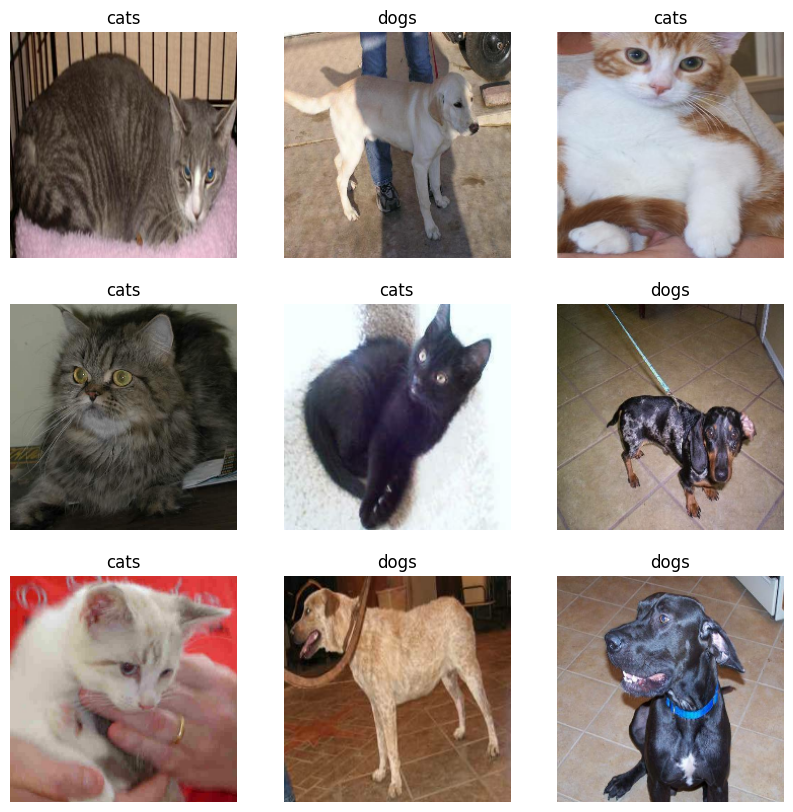

In [ ]:
# Muestra algunas imágenes de ejemplo
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)
    plt.title(class_names[class_idx])
    plt.axis("off")

Definir la arquitectura de la red:

In [ ]:
def build_model(input_shape, num_classes):
    base_model = tf.keras.applications.EfficientNetB0(input_shape=input_shape,
                                                include_top=False,
                                                weights='imagenet')
    base_model.trainable = False

    i = Input(shape=input_shape)
    x = base_model(i, training=False)
    x = GlobalMaxPooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(i, x)



Construir el modelo:

In [ ]:
print("Building model")
model = build_model((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Resumen del modelo:

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 1280)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Entrenar el modelo:

In [ ]:
# Número de épocas de entrenamiento
EPOCHS = 30
# Entrena el modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 391ms/step - accuracy: 0.7963 - loss: 0.9218 - val_accuracy: 0.9780 - val_loss: 0.1021
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.9861 - loss: 0.0655 - val_accuracy: 0.9840 - val_loss: 0.0618
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9885 - loss: 0.0399 - val_accuracy: 0.9790 - val_loss: 0.0710
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9916 - loss: 0.0241 - val_accuracy: 0.9850 - val_loss: 0.0575
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9928 - loss: 0.0168 - val_accuracy: 0.9870 - val_loss: 0.0554
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9970 - loss: 0.0190 - val_accuracy: 0.9870 - val_loss: 0.0551
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9892 - loss: 0.0296 - val_accuracy: 0.9850 - val_loss: 0.0573
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.9968 - loss: 0.0058 - val_accuracy: 0.9790 -

Visualizar resultados de entrenamiento:

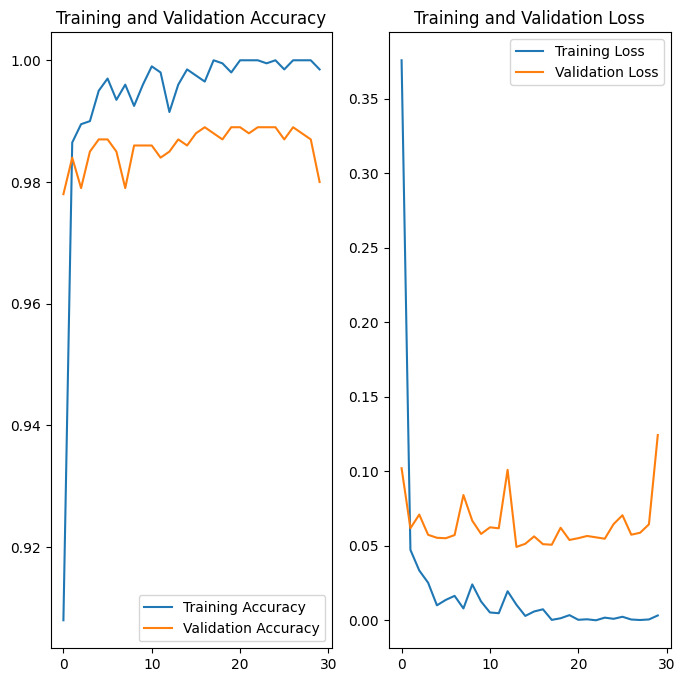

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


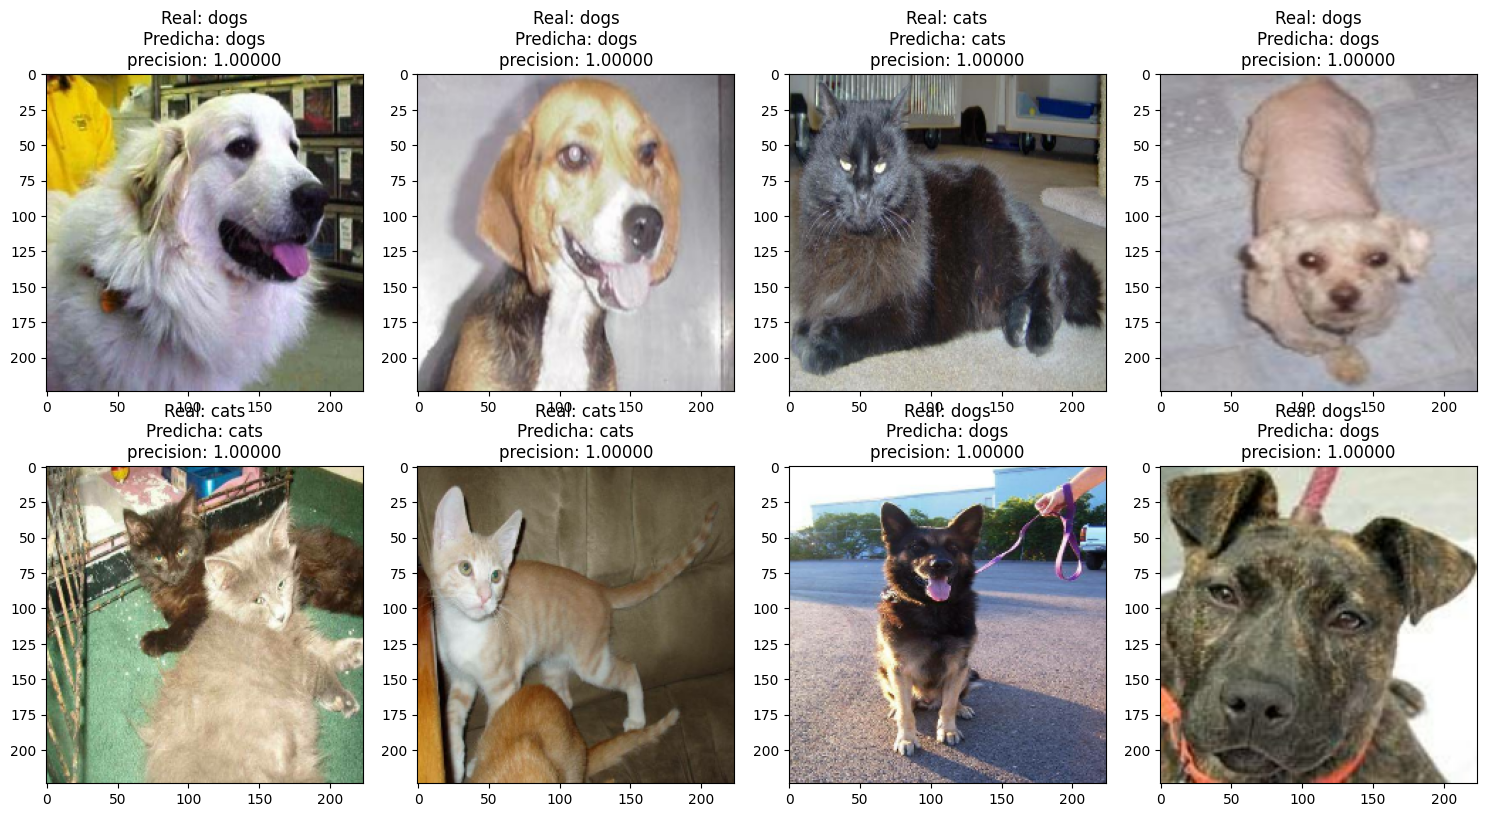

In [ ]:
for images, labels in val_ds.take(1):
    preds = model.predict(images)

true_classes = np.argmax(labels.numpy(), axis=1)
predicted_classes = np.argmax(preds, axis=1)
precision_confiaza = np.max(preds, axis=1)

N = 8
plt.figure(figsize=(15, 8))

for i in range(N):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    precision = precision_confiaza[i]
    predicted_class = class_names[predicted_classes[i]]
    true_class = class_names[true_classes[i]]

    plt.title(f"Real: {class_names[true_classes[i]]}\nPredicha: {class_names[predicted_classes[i]]}\nprecision: {precision:.5f}")


plt.tight_layout()
plt.show()